# Setup

In [44]:
import logging
import os 
import warnings
import platform
from pathlib import Path
from time import time

warnings.filterwarnings("ignore")
if "macOS" in platform.platform():
    os.chdir("/Users/erjo3868/repos/hypedsearch/hypedsearch")
# Running on Fiji
else:
    os.chdir("/scratch/Shares/layer/hypedsearch/hypedsearch")


# Ensure only one logger is configured
# Remove existing handlers if any
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging to ensure only one handler
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

from copy import deepcopy
import numpy as np
import pandas as pd
from itertools import product
from src.plot_utils import fig_setup, finalize, set_title_axes_labels
from src.utils import (
    pickle_and_compress, decompress_and_unpickle, get_time_in_diff_units,
    get_positions_of_subseq_in_seq, flatten_list_of_lists
)
from src.constants import (
    MOUSE_PROTEOME, IonTypes, WATER_MASS, PROTON_MASS, SPECTRA_DIR, COMET_EXECUTABLE,
    COMET_PARAMS, COMET_RUN_1_DIR
)
from src.peptides_and_ions import (
    Peptide, get_proteins_by_name, get_proteins_from_fasta, 
    Fasta, get_uniq_kmer_to_protein_map
)
from src.protein_product_ion_database import (
    ProteinProductIonDb, Protein, NewProductIon, PeakWithMatchingProductIons,
    PositionedIon, get_product_ions_matching_spectrum, create_db,
    process_peak_matching_ions, 
)
from src.comet_utils import (
    load_comet_data, CometPSM, run_comet 
)
from src.peptide_spectrum_comparison import (
    get_b_clusters, get_y_clusters, filter_clusters, extend_cluster, 
    get_hybrids_from_b_and_y_cluster, get_extended_clusters, get_clusters_from_ions, 
    get_possible_hybrids, create_new_fasta_including_hybrids, 
    # compare_peptide_to_spectrum, 
    PeptideSpectrumComparison
)

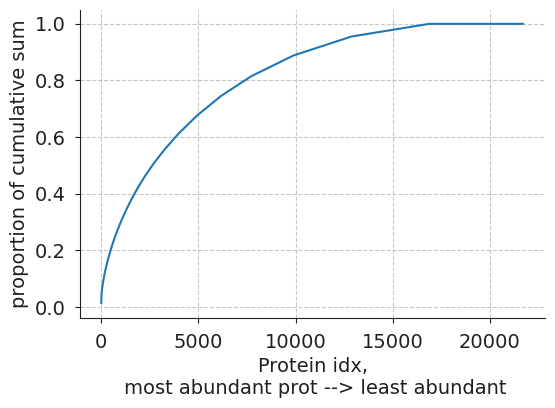

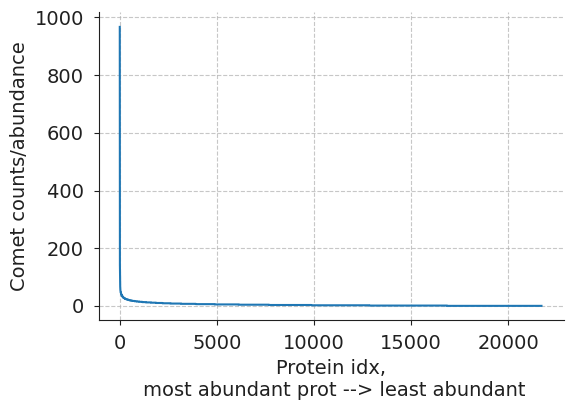

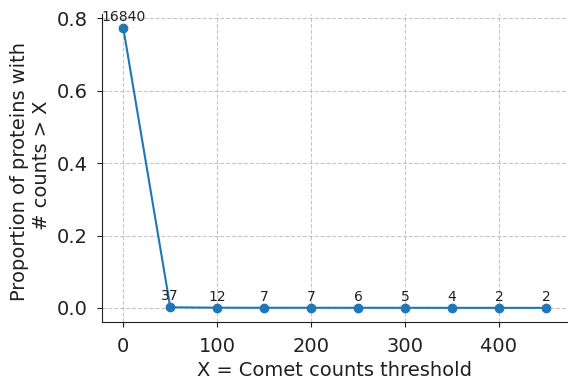

In [62]:
df = decompress_and_unpickle("results/protein_abundances.pkl")
df.sort_values("comet_counts", ascending=False, inplace=True, ignore_index=True)


_, axs = fig_setup(1, 1)
ax = axs[0]
data = np.cumsum(df["comet_counts"]) / sum(df["comet_counts"])
# ax.set_xlim(right=20)
_= ax.plot(
    range(1, len(data) + 1),
    data
)
set_title_axes_labels(
    ax=ax, 
    xlabel="Protein idx,\n most abundant prot --> least abundant",
    ylabel="proportion of cumulative sum"
)
finalize(axs)

_, axs = fig_setup(1, 1)
ax = axs[0]
# ax.set_xlim(right=20)
_ = ax.plot(
    df["comet_counts"]
)
set_title_axes_labels(
    ax=ax, 
    xlabel="Protein idx,\n most abundant prot --> least abundant",
    ylabel="Comet counts/abundance"
)
finalize(axs)

data = []
num_prots = df.shape[0]
for val in np.arange(0, 600, 50):
    num_prots_with_greater_abundance = sum(df["comet_counts"] > val)
    data.append([val, num_prots_with_greater_abundance, num_prots_with_greater_abundance / num_prots])
data = pd.DataFrame(
    data, 
    columns=["count_threshold", "num_prots_with_greater_ab", "prop_of_prots"]
)
data = data.iloc[0:10, :]

_, axs = fig_setup(1, 1)
ax = axs[0]
_=ax.plot(
    data["count_threshold"], data["prop_of_prots"],
    marker="o", linestyle="-",
)
# Label each point
for row_num, row in data.iterrows():
    _ = ax.annotate(
        int(row["num_prots_with_greater_ab"]),
        (row["count_threshold"], row["prop_of_prots"]), 
        textcoords="offset points", xytext=(0, 5), ha="center"
    )
set_title_axes_labels(
    ax=ax, 
    xlabel="X = Comet counts threshold",
    ylabel="Proportion of proteins with \n # counts > X"
)

finalize(axs)




Text(0, 5, '9')

Text(0, 5, '12')

Text(0, 5, '15')

Text(0, 5, '22')

Text(0, 5, '29')

Text(0, 5, '35')

Text(0, 5, '41')

Text(0, 5, '49')

Text(0, 5, '58')

Text(0, 5, '62')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Cumulative Sum')

Text(0.5, 1.0, 'Cumulative Sum with Data Labels')

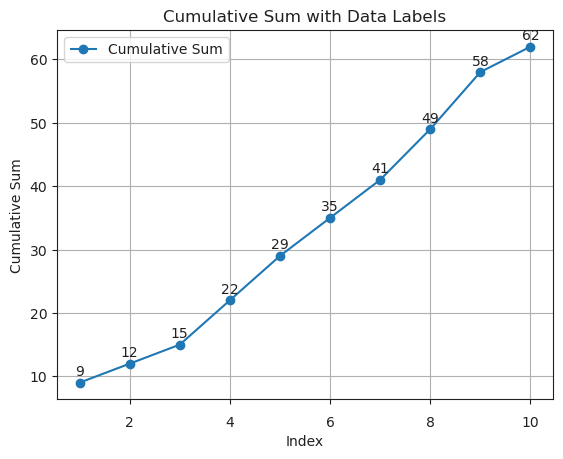

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
data = np.random.randint(1, 10, size=10)  # 10 random integers between 1 and 10

# Compute cumulative sum
cumsum = np.cumsum(data)

# Plot cumulative sum
plt.plot(range(1, len(data) + 1), cumsum, marker="o", linestyle="-", label="Cumulative Sum")

# Label each point
for i, txt in enumerate(cumsum):
    plt.annotate(txt, (i + 1, cumsum[i]), textcoords="offset points", xytext=(0, 5), ha="center")

# Labels and title
plt.xlabel("Index")
plt.ylabel("Cumulative Sum")
plt.title("Cumulative Sum with Data Labels")
plt.grid(True)
plt.legend()
plt.show()

# Pipeline

## Select spectrum

In [12]:
# Constants
from src.mass_spectra import get_specific_spectrum_by_sample_and_scan_num


top_n_peaks = 100
sample = "BMEM_AspN_Fxn4"
scan = 97
spectrum = get_specific_spectrum_by_sample_and_scan_num(sample=sample, scan_num=scan)

# # Load Comet deata
# df = load_comet_data()
# df.head(2)

# # Get a specific Comet row and the corresponding spectrum
# comet_row = CometPSM.from_dataframe(
#     df[(df["sample"] == sample) & (df["scan"]==scan)]
# )[0]


# spectrum = comet_row.get_corresponding_spectrum()

# Filter peaks
print(f"Number peaks PRE-filtering = {len(spectrum.peaks)}")
spectrum.filter_to_top_n_peaks(n=top_n_peaks)
print(f"Number peaks POST-filtering = {len(spectrum.peaks)}")

Number peaks PRE-filtering = 250
Number peaks POST-filtering = 100


## Define proteins to use

### Proteins with highest Comet counts

In [13]:
top_n_prots = 100
prot_abs = decompress_and_unpickle("results/protein_abundances.pkl")
prot_abs.sort_values("comet_counts", ascending=False, ignore_index=True, inplace=True)
prot_abs.head(2)
protein_names = list(prot_abs["full_name"].iloc[:top_n_prots])
protein_names[:3]

fasta = Fasta(fasta_path=MOUSE_PROTEOME)
fasta.proteins[0]

db_proteins = fasta.proteins_by_name(
    protein_names=protein_names
)
db_proteins[:3]
protein_id_to_name_map = {prot.id: prot.name for prot in db_proteins}

protein_id_to_name_map

,full_name,short_name,comet_counts,validated
0,sp|P01326|INS2_MOUSE,sp|P01326,971,1
1,sp|P01325|INS1_MOUSE,sp|P01325,586,1


['sp|P01326|INS2_MOUSE', 'sp|P01325|INS1_MOUSE', 'sp|P16014|SCG1_MOUSE']

Peptide(seq='MGRLTSSFLLLIVPAYVLSQVTLKESGPGILQPSQTLSLTCSFSGFSLSTSNMGIGWIRQPSGKGLEWLAHIWWNDDKYYNPSLKSRLTISKDTSNNQVFLKITSVDTADTATYYCAQI', name='tr|A0A0A6YY60|A0A0A6YY60_MOUSE', desc='tr|A0A0A6YY60|A0A0A6YY60_MOUSE Immunoglobulin heavy variable V8-5 (Fragment) OS=Mus musculus OX=10090 GN=Ighv8-5 PE=1 SV=1', id=0)

[Peptide(seq='MAPKGGSKQQSEEDLLLQDFSRNLSAKSSALFFGNAFIVSAIPIWLYWRIWHMDLIQSAVLYSVMTLVSTYLVAFAYKNVKFVLKHKVAQKREDAVSKEVTRKLSEADNRKMSRKEKDERILWKKNEVADYEATTFSIFYNNTLFLVLVIVASFFILKNFNPTVNYILSISASSGLIALLSTGSK', name='sp|Q9DCF9|SSRG_MOUSE', desc='sp|Q9DCF9|SSRG_MOUSE Translocon-associated protein subunit gamma OS=Mus musculus OX=10090 GN=Ssr3 PE=1 SV=1', id=291),
 Peptide(seq='MGTIGVPLTAHCVVLFLLQMVALSTEQFTVNGLESPVLVPLGGNLELSCQLSPPQQAKHMEIRWFKNRYSEPVYLYRNGKDLNEAIVYKYVERTELLKDDIGKGKVTLRIFKVTSVDSGSYHCFFKDDKFYEEHIIEVKVTATSSDIQILMHPPNSTGVRLECHSGGWFPQPHMEWRDSKGEYIPATSKSHSQDENEFFNMTMDLFIKSNSYWSAACYIQNFVTHQEESISFVLPGTKVLLLKNIQSIFQSSSVDLEKKDMLLKSIKSRFQSSSVDPEKKERLLKIIQSRIESSSVDQETKALLLESIQSSIENSTVDLETKVWLLESIKSSIQNSSVDPETKELLLERIKSSIENSTVDLGTKEWLLESIQSSIQSSSVDLGTKKMLLKIIQSSIQSFSVYIGTKEWLLERVQSSIQSSSVDLGTKELLLEIIQSSIEGYSVELGIEELLSKIILSSIQSSRVDLGIKELLVKICQSSIQSTSVILETKEWLVKIFQSNIQSSSMDLETKVWLVKFFQSSIQSSSMDLGTIKWLVKNVQSNIQSSRVDLETKRMLLEIIQSSIQNSSVHRGTKKMLLKVIQSSIQSFSVDLETKEWLLKIIQSSIQSSSVDIGTKSMLLKKIGLILRSS

{291: 'sp|Q9DCF9|SSRG_MOUSE',
 311: 'sp|A7XUZ6|SKIT6_MOUSE',
 344: 'sp|Q60997|DMBT1_MOUSE',
 423: 'sp|P08121|CO3A1_MOUSE',
 804: 'tr|A0A571BGC3|A0A571BGC3_MOUSE',
 855: 'sp|Q61048|WBP4_MOUSE',
 913: 'sp|O70405|ULK1_MOUSE',
 1744: 'sp|Q5SSE9|ABCAD_MOUSE',
 1927: 'sp|P01942|HBA_MOUSE',
 1951: 'sp|Q64507|KRA51_MOUSE',
 2627: 'sp|P55200|KMT2A_MOUSE',
 2702: 'tr|A0A9L6KE92|A0A9L6KE92_MOUSE',
 2799: 'sp|Q9Z1K7|APCL_MOUSE',
 3035: 'sp|Q04690|NF1_MOUSE',
 3101: 'tr|A0A140LJ72|A0A140LJ72_MOUSE',
 3116: 'sp|P01326|INS2_MOUSE',
 3254: 'sp|Q80W93|HYDIN_MOUSE',
 3404: 'tr|A0A571BEV2|A0A571BEV2_MOUSE',
 3767: 'sp|Q8CG65|SSPO_MOUSE',
 3805: 'sp|A2AAJ9|OBSCN_MOUSE',
 4229: 'sp|P47867|SCG3_MOUSE',
 4304: 'tr|A0A286YCV9|A0A286YCV9_MOUSE',
 4482: 'sp|Q9CQR2|RS21_MOUSE',
 4528: 'sp|P12961|7B2_MOUSE',
 5363: 'sp|Q6P4S8|INT1_MOUSE',
 5505: 'sp|A7XUY5|SKIT5_MOUSE',
 5732: 'sp|P99028|QCR6_MOUSE',
 5831: 'sp|P60060|SC61G_MOUSE',
 6502: 'sp|A2ARZ3|FSIP2_MOUSE',
 6751: 'sp|Q3UQ44|IQGA2_MOUSE',
 6757: 'sp|Q61245|

## Full pipeline

Examples of how long the full pipeline has taken:

- Inputs: 100 DB proteins 
  - 1m5s

In [14]:
# Constants
parent_dir = Path("tmp/test").absolute()
db_path = parent_dir / "new.db"
new_fasta_path = parent_dir / "test.fasta"
mzml_path = (SPECTRA_DIR / f"{spectrum.mzml}.mzML").absolute()
comet_run_1_txt = COMET_RUN_1_DIR / f"{spectrum.mzml}/{spectrum.mzml}.txt"
uniq_kmer_to_protein_map_path = parent_dir / "uniq_kmer_to_protein.pkl"

# Create HS DB
if not uniq_kmer_to_protein_map_path.exists():
    logger.info("Unique kmer-to-protein map does NOT exist. Creating it...")
    uniq_kmer_to_protein_map = get_uniq_kmer_to_protein_map(proteins=db_proteins)
    pickle_and_compress(
        obj=uniq_kmer_to_protein_map,
        file_path=uniq_kmer_to_protein_map_path
    )
else:
    logger.info("Unique kmer-to-protein map exists. Using existing one...")
    uniq_kmer_to_protein_map = decompress_and_unpickle(file_path=uniq_kmer_to_protein_map_path)

db = create_db(
    db_path=db_path, 
    db_proteins=db_proteins, 
    uniq_kmers=uniq_kmer_to_protein_map.keys(),
    overwrite=False
)

# Find ions that match spectrum peaks
peaks_with_matches = get_product_ions_matching_spectrum(
    spectrum=spectrum,
    db=db,
)
positioned_ions = process_peak_matching_ions(
    peaks_with_matches=peaks_with_matches,
    kmer_to_protein_map=uniq_kmer_to_protein_map,
    db=db
)

# Get clusters
clusters = get_clusters_from_ions(ions=positioned_ions)
extended_clusters = get_extended_clusters(spectrum_clusters=clusters, spectrum=spectrum, db=db)

# Get possible hybrids
possible_hybrids = get_possible_hybrids(
    extended_clusters=extended_clusters,
    spectrum=spectrum
)

2025-03-20 13:47:41,865 - __main__ - INFO - Unique kmer-to-protein map exists. Using existing one...
2025-03-20 13:47:45,501 - src.sql_database - INFO - The database already exists at /Users/erjo3868/repos/hypedsearch/hypedsearch/tmp/test/new.db.
2025-03-20 13:47:45,501 - src.sql_database - INFO - 'overwrite' is False so connecting to the existing one.
2025-03-20 13:47:46,857 - src.protein_product_ion_database - INFO - Peak-to-product-ion matching took 1.35 secs = 0.02 mins = 0.0 hrs
2025-03-20 13:47:48,578 - src.peptide_spectrum_comparison - INFO - Before filtering, number b-clusters = 53491; number y-clusters = 41202
2025-03-20 13:47:48,591 - src.peptide_spectrum_comparison - INFO - After filtering, number b-clusters = 7427; number y-clusters = 5380
2025-03-20 13:47:48,858 - src.peptide_spectrum_comparison - INFO - Getting extended clusters took 0.27 seconds
2025-03-20 13:47:48,859 - src.peptide_spectrum_comparison - INFO - Creating possible hybrids...
2025-03-20 13:48:42,181 - src.p

In [15]:
# Create new FASTA with hybrids
create_new_fasta_including_hybrids(
    db_proteins=db_proteins,
    hybrids=possible_hybrids,
    protein_id_to_name_map=protein_id_to_name_map,
    fasta_path=new_fasta_path
)

# Run Comet
comet_run_2_txt = run_comet(
    template_comet_params_path=COMET_PARAMS,
    fasta_path=new_fasta_path,
    parent_output_dir=parent_dir,
    comet_exe_path=COMET_EXECUTABLE, 
    mzml_path=mzml_path,
)

# Get Comet run 1 vs 2 results
comet_run_1_rows = CometPSM.from_txt(file_path=comet_run_1_txt)
run_1_rows_for_spectrum = list(
    filter(
        lambda comet_row: comet_row.scan == spectrum.scan_num, comet_run_1_rows
    )
)

comet_run_2_rows = CometPSM.from_txt(file_path=comet_run_2_txt)
run_2_rows_for_spectrum = list(
    filter(
        lambda comet_row: comet_row.scan == spectrum.scan_num, comet_run_2_rows
    )
)

2025-03-20 13:48:50,307 - root - INFO - Calling run_comet with args: () and kwargs: {'template_comet_params_path': PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/comet/comet.params'), 'fasta_path': PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/tmp/test/test.fasta'), 'parent_output_dir': PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/tmp/test'), 'comet_exe_path': PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/comet/comet.macos.exe'), 'mzml_path': PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/data/spectra/BMEM_AspN_Fxn4.mzML')}
2025-03-20 13:48:50,308 - src.utils - INFO - /Users/erjo3868/repos/hypedsearch/hypedsearch/tmp/test already exists
2025-03-20 13:48:50,308 - src.utils - INFO - /Users/erjo3868/repos/hypedsearch/hypedsearch/tmp/test/BMEM_AspN_Fxn4 already exists
2025-03-20 13:48:50,346 - src.comet_utils - INFO - Running Comet with command:
/Users/erjo3868/repos/hypedsearch/hypedsearch/comet/comet.macos.exe /Users/erjo3868/repos/hy

In [ ]:
run_1_rows_for_spectrum
run_2_rows_for_spectrum




[CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='PGSAAPAAGSAPAAAEEKK', ions_matched=33, proteins=['tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE', 'sp|P99027|RLA2_MOUSE'], protein_count=2, xcorr=4.468, eval=3.29e-12, delta_cn=0.6426),
 CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='ASPGAAPGPRRERPDF', ions_matched=10, proteins=['sp|Q7TSF4|LR75A_MOUSE'], protein_count=1, xcorr=1.597, eval=0.833, delta_cn=0.0683),
 CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='LVFDVTAPNTFKTLD', ions_matched=9, proteins=['sp|P51150|RAB7A_MOUSE'], protein_count=1, xcorr=1.488, eval=2.26, delta_cn=0.0329),
 CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='GPASAAGALSGGTPTQLQP', ions_matched=10, proteins=['sp|Q9WVH4|FOXO3_MOUSE'], protein_count=1, xcorr=1.439, eval=3.53, delta_cn=0.0257),
 CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='LCRSTTSALAAVCIRGG', ions_matched=8, proteins=['tr|Q8R5F9|Q8R5F9_MOUSE'], protein_count=1, xcorr=1.402, eval=4.96, delta_cn=0

[CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='PGSAAPAAGSAPAATKIEN', ions_matched=32, proteins=['hybrid-195625-tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE_PGSAAPAAGSAPAA-sp|Q91ZU6|DYST_MOUSE_TKIEN', 'hybrid-228501-sp|P99027|RLA2_MOUSE_PGSAAPAAGSAPAA-sp|Q91ZU6|DYST_MOUSE_TKIEN'], protein_count=2, xcorr=4.61, eval=0.0109, delta_cn=0.015),
 CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='PGSAAPAAGSAPAAAMLRN', ions_matched=33, proteins=['hybrid-195452-tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE_PGSAAPAAGSAPAAA-sp|Q9Z1K7|APCL_MOUSE_MLRN', 'hybrid-195952-tr|A0A5F8MPY2|A0A5F8MPY2_MOUSE_PGSAAPAAGSAPAAA-sp|Q6ZWQ0|SYNE2_MOUSE_MLRN', 'hybrid-228328-sp|P99027|RLA2_MOUSE_PGSAAPAAGSAPAAA-sp|Q9Z1K7|APCL_MOUSE_MLRN', 'hybrid-228828-sp|P99027|RLA2_MOUSE_PGSAAPAAGSAPAAA-sp|Q6ZWQ0|SYNE2_MOUSE_MLRN'], protein_count=4, xcorr=4.555, eval=0.0139, delta_cn=0.0031),
 CometPSM(sample='BMEM_AspN_Fxn4', scan=97, proposed_peptide='PGSAAPAAGSAPAAAMRLN', ions_matched=33, proteins=['hybrid-195782-tr|A0A5F8MPY2|A0A5

In [83]:
row = run_2_rows_for_spectrum[0]
psm = row.compare(spectrum=spectrum)
psm.prop_intensity_supported_by_peptide
psm.total_intensity
sum([peak.intensity for peak in spectrum.peaks])

0.38877044876304784

49712.06303405762

49712.06303405762

In [ ]:
psm.prop_intensity_supported_by_peptide
psm.total_intensity
spectrum.
sum([peak.abundance for peak in spectrum.peaks])

0.33077504820650266

60243.97904968262

49712.06303405762

# Pipeline separated out by section

## Create HS DB

For 100 proteins, creating the DB took ~20 seconds.

In [4]:
# Constants
parent_dir = Path("tmp/test").absolute()
db_path = parent_dir / "new.db"

uniq_kmer_to_protein_map, db = create_db(db_path=db_path, db_proteins=db_proteins)

2025-03-17 17:21:03,994 - src.sql_database - INFO - The database already exists at /Users/erjo3868/repos/hypedsearch/hypedsearch/tmp/test/new.db.
2025-03-17 17:21:03,996 - src.sql_database - INFO - 'overwrite' is True so deleting the existing databse and starting anew.
2025-03-17 17:21:04,007 - src.sql_database - INFO - Created table proteins
2025-03-17 17:21:04,009 - src.sql_database - INFO - Created table product_ions
2025-03-17 17:21:04,013 - src.peptides_and_ions - INFO - Processing protein 1 of 100
2025-03-17 17:21:04,023 - src.peptides_and_ions - INFO - 	 took 0.01 seconds
2025-03-17 17:21:04,024 - src.peptides_and_ions - INFO - Processing protein 2 of 100
2025-03-17 17:21:04,085 - src.peptides_and_ions - INFO - 	 took 0.06 seconds
2025-03-17 17:21:04,086 - src.peptides_and_ions - INFO - Processing protein 3 of 100
2025-03-17 17:21:04,176 - src.peptides_and_ions - INFO - 	 took 0.09 seconds
2025-03-17 17:21:04,177 - src.peptides_and_ions - INFO - Processing protein 4 of 100
2025-

## Find ions that match peak

In [6]:
# Constants
# ion_types = [IonTypes.B_ION_TYPE, IonTypes.Y_ION_TYPE]
# peak_product_ion_ppm_tolerance = 10

from typing import List


peaks_with_matches = get_product_ions_matching_spectrum(
    spectrum=spectrum,
    db=db,
)
positioned_ions = process_peak_matching_ions(
    peaks_with_matches=peaks_with_matches,
    kmer_to_protein_map=uniq_kmer_to_protein_map,
    db=db
)
positioned_ions[:3]
positioned_ions[-3:]

2025-03-17 17:21:47,768 - src.protein_product_ion_database - INFO - Peak-to-product-ion matching took 0.18 secs = 0.0 mins = 0.0 hrs


[PositionedIon(seq='S', charge=1, ion_type='b', protein_id=291, inclusive_start=6, exclusive_end=7),
 PositionedIon(seq='S', charge=1, ion_type='b', protein_id=291, inclusive_start=10, exclusive_end=11),
 PositionedIon(seq='S', charge=1, ion_type='b', protein_id=291, inclusive_start=20, exclusive_end=21)]

[PositionedIon(seq='PERALPRQ', charge=1, ion_type='y', protein_id=17012, inclusive_start=275, exclusive_end=283),
 PositionedIon(seq='HRLLTAQQ', charge=1, ion_type='y', protein_id=21552, inclusive_start=3852, exclusive_end=3860),
 PositionedIon(seq='SILARAQHA', charge=1, ion_type='y', protein_id=1744, inclusive_start=3162, exclusive_end=3171)]

## Get clusters

In [7]:
clusters = get_clusters_from_ions(ions=positioned_ions)
extended_clusters = get_extended_clusters(spectrum_clusters=clusters, spectrum=spectrum, db=db)

2025-03-17 17:21:51,434 - src.peptide_spectrum_comparison - INFO - Before filtering, number b-clusters = 99900; number y-clusters = 83463
2025-03-17 17:21:51,457 - src.peptide_spectrum_comparison - INFO - After filtering, number b-clusters = 9126; number y-clusters = 5306
2025-03-17 17:21:51,733 - src.peptide_spectrum_comparison - INFO - Getting extended clusters took 0.27 seconds


In [8]:
extended_clusters.b[0].seqs

[SeqWithMz(seq='EPVYLY', mz=392.19980476688005),
 SeqWithMz(seq='EPVYLYR', mz=470.25036026688),
 SeqWithMz(seq='EPVYLYRN', mz=527.27182396688),
 SeqWithMz(seq='EPVYLYRNG', mz=555.78255581688)]

## Get possible hybrids

Here are some example timings of how long this step has taken:

- number b-clusters = 9126; number y-clusters = 5306
  - 24 seconds
  - 45 seconds

In [9]:
possible_hybrids = get_possible_hybrids(
    extended_clusters=extended_clusters,
    spectrum=spectrum
)

In [13]:
new_fasta_path = Path("tmp/test.fasta").absolute()
create_new_fasta_including_hybrids(
    db_proteins=db_proteins,
    hybrids=possible_hybrids,
    protein_id_to_name_map=protein_id_to_name_map,
    fasta_path=new_fasta_path
)